In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
class Environment:
    """A simple grid world environment where an agent navigates from start to goal."""
    
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.state = (0, 0)  # Starting position (top-left)
        self.goal = (grid_size - 1, grid_size - 1)  # Goal position (bottom-right)
        
        # Actions: 0: up, 1: right, 2: down, 3: left
        self.actions = [(0, -1), (1, 0), (0, 1), (-1, 0)]
        self.num_actions = len(self.actions)
        
    def reset(self):
        """Reset the environment to initial state."""
        self.state = (0, 0)
        return self.state
    
    def step(self, action):
        """Execute action and return new state, reward and done flag."""
        # Move according to action
        direction = self.actions[action]
        new_x = max(0, min(self.grid_size - 1, self.state[0] + direction[0]))
        new_y = max(0, min(self.grid_size - 1, self.state[1] + direction[1]))
        self.state = (new_x, new_y)
        
        # Check if goal is reached
        done = (self.state == self.goal)
        
        # Reward: -1 for each step, +10 for reaching goal
        reward = 10 if done else -1
        
        return self.state, reward, done
    
    def get_state_index(self, state):
        """Convert 2D state to 1D index."""
        return state[0] * self.grid_size + state[1]
    
    def get_total_states(self):
        """Return total number of possible states."""
        return self.grid_size * self.grid_size

Training agent...
Episode: 100, Average Reward: -32.29, Exploration Rate: 0.61
Episode: 200, Average Reward: -3.26, Exploration Rate: 0.37
Episode: 300, Average Reward: -0.70, Exploration Rate: 0.22
Episode: 400, Average Reward: 1.06, Exploration Rate: 0.13
Episode: 500, Average Reward: 2.09, Exploration Rate: 0.08
Episode: 600, Average Reward: 2.48, Exploration Rate: 0.05
Episode: 700, Average Reward: 2.72, Exploration Rate: 0.03
Episode: 800, Average Reward: 2.74, Exploration Rate: 0.02
Episode: 900, Average Reward: 2.82, Exploration Rate: 0.01
Episode: 1000, Average Reward: 2.92, Exploration Rate: 0.01
Learned Policy:
↓ ↓ ↓ ↓ ↓
→ ↓ ↓ ↓ ↓
→ ↓ → ↓ ↓
→ → ↓ ↓ ↓
→ → → → G


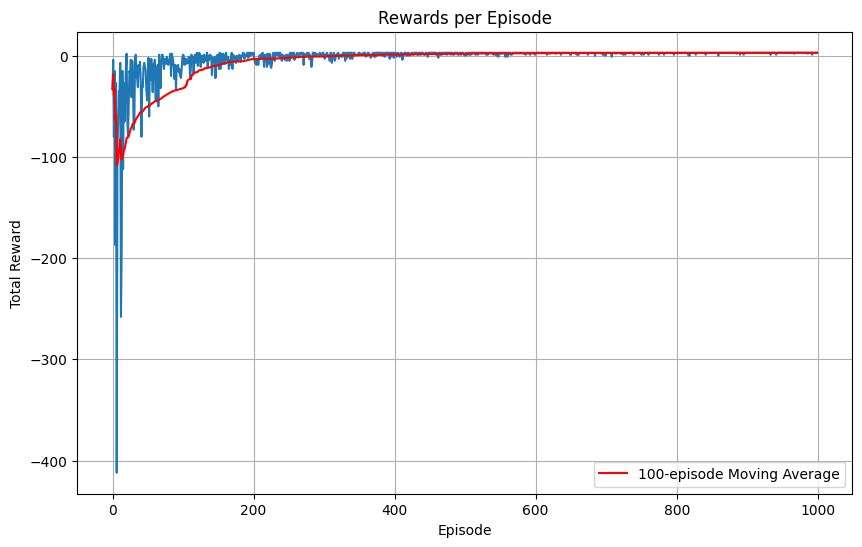

In [3]:


class QLearningAgent:
    """Q-learning agent implementation."""
    
    def __init__(self, num_states, num_actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = 0.995  # Decay rate for exploration
        self.min_exploration = 0.01  # Minimum exploration rate
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((num_states, num_actions))
        
    def select_action(self, state_idx):
        """Select action using epsilon-greedy policy."""
        if random.random() < self.exploration_rate:
            # Explore: choose a random action
            return random.randint(0, self.num_actions - 1)
        else:
            # Exploit: choose the best action from Q-table
            return np.argmax(self.q_table[state_idx])
    
    def update_q_table(self, state_idx, action, reward, next_state_idx, done):
        """Update Q-value using the Q-learning update rule."""
        # Get current Q-value
        current_q = self.q_table[state_idx][action]
        
        # Calculate new Q-value
        if done:
            max_future_q = 0
        else:
            max_future_q = np.max(self.q_table[next_state_idx])
        
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q)
        
        # Update Q-table
        self.q_table[state_idx][action] = new_q
        
    def decay_exploration(self):
        """Decay the exploration rate."""
        self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.exploration_decay)

def train_agent(env, agent, num_episodes=1000):
    """Train the agent for a specified number of episodes."""
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        state = env.reset()
        state_idx = env.get_state_index(state)
        total_reward = 0
        done = False
        
        while not done:
            # Select and perform action
            action = agent.select_action(state_idx)
            next_state, reward, done = env.step(action)
            next_state_idx = env.get_state_index(next_state)
            
            # Update Q-table
            agent.update_q_table(state_idx, action, reward, next_state_idx, done)
            
            # Update state
            state_idx = next_state_idx
            total_reward += reward
        
        # Decay exploration rate
        agent.decay_exploration()
        
        # Track rewards
        rewards_per_episode.append(total_reward)
        
        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_reward = sum(rewards_per_episode[-100:]) / 100
            print(f"Episode: {episode + 1}, Average Reward: {avg_reward:.2f}, Exploration Rate: {agent.exploration_rate:.2f}")
    
    return rewards_per_episode

def visualize_policy(env, agent):
    """Visualize the learned policy."""
    policy = np.zeros((env.grid_size, env.grid_size), dtype=str)
    arrows = ["↑", "→", "↓", "←"]
    
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            state_idx = env.get_state_index((i, j))
            best_action = np.argmax(agent.q_table[state_idx])
            policy[j, i] = arrows[best_action]  # Note the j, i order for visualization
    
    # Mark the goal state
    policy[env.goal[1], env.goal[0]] = "G"
    
    print("Learned Policy:")
    for row in policy:
        print(" ".join(row))

def plot_rewards(rewards):
    """Plot the rewards per episode."""
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Plot moving average
    window_size = 100
    moving_avg = [sum(rewards[max(0, i-window_size):i]) / min(i, window_size) for i in range(1, len(rewards) + 1)]
    plt.plot(moving_avg, color='red', label=f'{window_size}-episode Moving Average')
    
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create environment and agent
    env = Environment(grid_size=5)
    agent = QLearningAgent(
        num_states=env.get_total_states(),
        num_actions=env.num_actions,
        learning_rate=0.1,
        discount_factor=0.9,
        exploration_rate=1.0
    )
    
    # Train the agent
    print("Training agent...")
    rewards = train_agent(env, agent, num_episodes=1000)
    
    # Visualize the learned policy
    visualize_policy(env, agent)
    
    # Plot the rewards
    plot_rewards(rewards)